# Using EOF analysis for noise reduction in your data
#### by Elizabeth Barnes

Demonstration of how to use EOF analysis to remove "noise" from your data set.

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

#.............................................
# IMPORT STATEMENTS
#.............................................
import numpy as np
import matplotlib.pyplot as plt
import importlib
import scipy.stats as stats
import numpy.linalg as LA
from mpl_toolkits.basemap import Basemap

import general_functions as gf
importlib.reload(gf)
gf.add_parent_dir_to_path()

from lib import class_general_functions as cgf
importlib.reload(cgf)

#.............................................
# PLOTTING COMMANDS
#.............................................
gf.cc()
plt.ioff()

# ignore matplotlib deprecation warning
import warnings
warnings.filterwarnings("ignore")

### User input

In [2]:
eof_number = np.arange(0,17) #how many EOFs to retain
month_to_plot = 100

### Data Description

2-meter monthly air temperature from ERA-Interim reanalysis. Below I sub-sample the data to only grab every fourth gridbox (to reduce the data size).

In [3]:
filename = 'data/Temperature_2meters_monthly_ERAInterim.csv'
X = np.genfromtxt(filename, delimiter = ',')
X = X[:,0:-1:4]

filename = 'data/LAT_LONG.csv'
LAT_LONG = np.genfromtxt(filename, delimiter = ',')
LAT = LAT_LONG[0:-1:4,0]
LONG = LAT_LONG[0:-1:4,1]

### Calculate the EOFs

In [4]:
# calculate the covariance matrix in the spatial dimension
C = 1./np.size(X,axis = 1)*(np.dot(X,np.transpose(X)))

# calculate eigenvalues and eigenvectors of C
lam, Z = LA.eig(C)
E = np.dot(np.transpose(Z),X)

# sort eigenvalues and vector by the largest to smallest eigenvalues
i = np.flipud(np.argsort(lam))
lam = lam[i]
E = E[i,:]

# convert eigenvalues to percent variance explained
pve = 100.*lam/np.sum(lam)


### Retain only the first few EOFs and reconstruct the data X

In [5]:
# reduce E and Z to the number of eofs you want to retain,
# then reconstruct X

# retain only certain eofs
Z = Z[:,eof_number]
E = E[eof_number,:]

# reconstruct X
Xrecon = np.dot(Z,E)

### Plot the results: eigenvalues

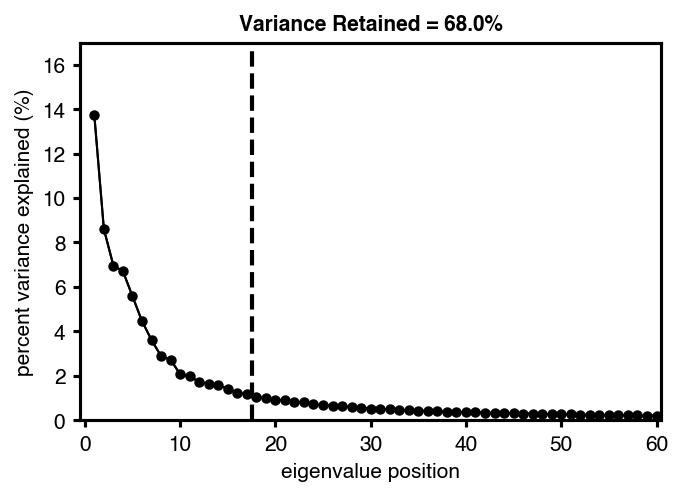

In [6]:
# plot results: EIGENVALUES
cgf.cfig(1)
plt.plot(np.arange(1,np.size(pve)+1.),pve,'o-',linewidth = 1, color = 'black', markersize = 4)

plt.plot([np.max(eof_number)+1.5,np.max(eof_number)+1.5],[0,20],'--k')

plt.title('Variance Retained = ' + str(np.round(np.sum(pve[eof_number]))) + '%')

plt.xlim(-0.5, 60.5)
plt.ylim(0,17.)
plt.xlabel('eigenvalue position')
plt.ylabel('percent variance explained (%)')

# plot error bars according to North et al.abs
# here we will assume that all of the data is independent (is that a good assumption?)
# such that Nstar = N
Nstar = np.size(X,axis = 1)
eb = pve*np.sqrt(2./Nstar)
plt.errorbar(np.arange(1,np.size(pve)+1.),pve,yerr = eb/2, xerr = None, linewidth = 1, color = 'black')

plt.show()

### Plot the results: get data ready for making a map

In [7]:
# plot results
LATu = np.unique(LAT)
LONGu = np.unique(LONG)

P_PLOT = np.empty((np.size(LATu),np.size(LONGu)))
P_PLOT_orig = np.empty((np.size(LATu),np.size(LONGu)))

for ilat,lat in enumerate(LATu):
    for ilon,lon in enumerate(LONGu):
        
        j = np.where(np.logical_and(LAT==lat,LONG==lon))
        P_PLOT[ilat,ilon] = Xrecon[month_to_plot-1,j]
        P_PLOT_orig[ilat,ilon] = X[month_to_plot-1,j]

lons, lats = np.meshgrid(LONGu,LATu)

### Plot the results: compare the raw map and the smoothed map

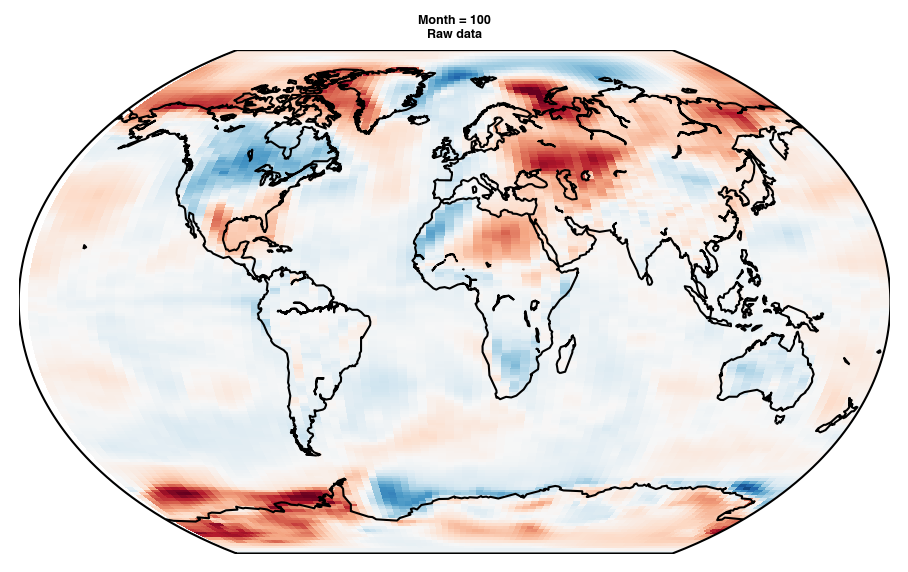

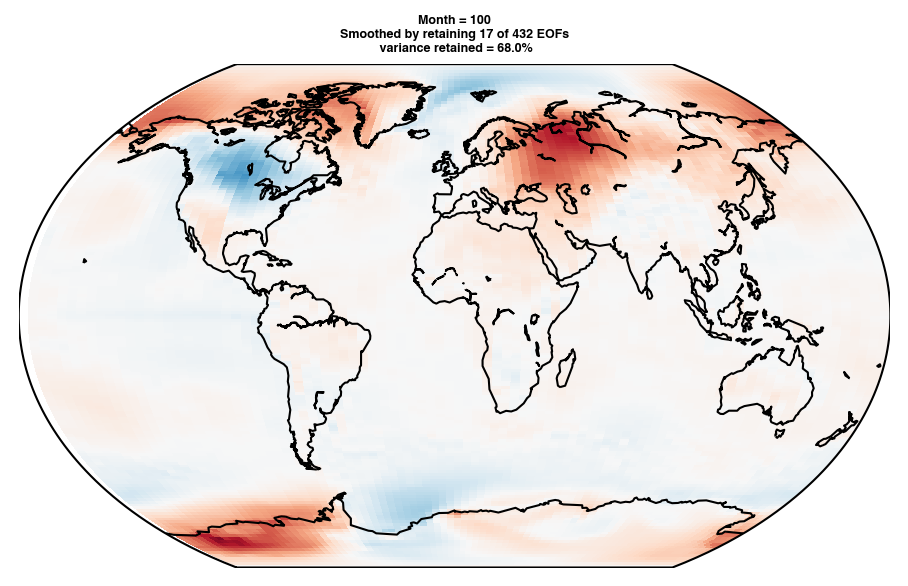

In [8]:
#------------------- RAW DATA -------------------------

cgf.cfig(4, fig_width = cgf.fig_width*1.5, fig_height = cgf.fig_height*1.5)
m = Basemap(projection='kav7',lon_0=0,resolution='c')
m.drawcoastlines(linewidth = 1)
im1 = m.pcolormesh(lons,lats,P_PLOT_orig,shading='flat',cmap=plt.cm.RdBu,latlon=True)
plt.clim(-8,8)
plt.title('Month = ' + str(month_to_plot) + '\nRaw data', fontsize = 6)
plt.axis('off')
plt.show()

#------------------- SMOOTHED DATA -------------------------
cgf.cfig(5, fig_width = cgf.fig_width*1.5, fig_height = cgf.fig_height*1.5)
m = Basemap(projection='kav7',lon_0=0,resolution='c')
m.drawcoastlines(linewidth = 1)
im1 = m.pcolormesh(lons,lats,P_PLOT,shading='flat',cmap=plt.cm.RdBu,latlon=True)
#cb = m.colorbar(im1,"bottom", size="5%", pad="2%")
plt.clim(-8,8)
plt.title('Month = ' + str(month_to_plot) + '\nSmoothed by retaining ' + str(np.max(eof_number)+1) + ' of ' + str(np.size(lam)) + ' EOFs\n variance retained = ' + str(np.round(np.sum(pve[eof_number]))) + '%', fontsize = 6)
plt.axis('off')
plt.show()
